## 1. Introducion

El Aprendizaje por Refuerzo (Reinforcement Learning) constituye una de las áreas más relevantes del campo del Aprendizaje Automático, al centrarse en la interacción entre un agente y su entorno mediante un proceso de toma de decisiones secuencial. A diferencia de los enfoques supervisados, donde el aprendizaje se basa en ejemplos con etiquetas, en  RL el conocimiento se adquiere a través de la experiencia directa: el agente ejecuta acciones, 
observa las consecuencias y ajusta su comportamiento para maximizar la recompensa acumulada. 
En este contexto, los entornos GridWorld proporcionan un escenario simplificado pero ilustrativo para estudiar los fundamentos del Reinforcement Learning. Estos entornos discretos permiten modelar conceptos de estado, acción y recompensa, así como analizar la evolución del aprendizaje mediante políticas y funciones de valor. El presente trabajo implementa un agente que interactúa dentro de un entorno laberinto de 8×7 celdas, en el cual debe aprender a alcanzar una meta optimizando su comportamiento mediante la definición de una función de recompensas y un conjunto de acciones posibles.

## 2. Propocito del agente

El propósito del agente consiste en aprender una política óptima que maximice la recompensa acumulada al desplazarse dentro del entorno laberinto. Desde un estado inicial (punto rojo), el agente puede ejecutar acciones que modifican su posición dentro de la  cuadrícula de 8×7 . El desafío consiste en descubrir, mediante exploración y aprendizaje, la secuencia de acciones (política) que maximiza la recompensa final.

## 3. Objetivo

El objetivo en este punto intermedio del desarrollo del proyecto es caracterizar los elementos que componen la solución del problema de navegación del agente en el entorno GridWorld. Esto implica definir los elementos del entorno de Reinforcement Learning: el conjunto de estados, las acciones posibles y la función de recompensa; 
siendo estos los que determinan el comportamiento del agente y la forma en que aprende su tarea: alcanzar la meta.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.animation as animation
from IPython.display import Image, display, clear_output
import matplotlib.animation as animation
import time
import matplotlib.patches as patches
from PIL import Image
import io
from utils import generate_video_with_qvalues
# Configurar matplotlib para mostrar gráficos en el notebook
%matplotlib inline

In [2]:
class Maze:
    def __init__(self, file=None, start=(6,0), goal=(1,6)):
        """
        Inicializa el laberinto.
        Coordenadas de celdas: (fila, columna) con fila en [0,n-1], columna en [0,m-1].
        El archivo describe segmentos de pared en coordenadas de vértices (x,y) donde
        x=fila de vértice, y=columna de vértice, y esos rangos van 0..n y 0..m.
        start: posición inicial dentro de la grilla.
        goal: posición objetivo dentro de la grilla.
        """
        self.n = 0  # filas
        self.m = 0  # columnas
        self.paredes = []  # lista de segmentos de pared [(x1, y1, x2, y2), ...]
        self.input = []  # lista de estados de entrada (columna 0 sin muro izquierdo)
        self.exit = []   # lista de estados de salida (columna m-1 sin muro derecho)
        if file:
            self.load_from_file(file)
            self.get_start_end()

    def load_from_file(self, file):
        """
        Carga el laberinto desde un archivo de texto.
        Primera línea: n m (filas columnas)
        Segunda línea: k (cantidad de segmentos)
        Siguientes k líneas: x1 y1 x2 y2 (segmentos entre vértices)
        """
        with open(file, 'r') as f:
            lineas = [linea.strip() for linea in f.readlines() if linea.strip()]
        self.n, self.m = map(int, lineas[0].split())
        k = int(lineas[1])
        if len(lineas) < 2 + k:
            raise ValueError(f"El archivo debe tener al menos {2 + k} líneas, pero solo tiene {len(lineas)}")
        self.paredes = []
        for i in range(2, 2 + k):
            x1, y1, x2, y2 = map(int, lineas[i].split())
            self.paredes.append((x1, y1, x2, y2))

    def _is_left_wall(self, row):
        """Verifica si hay un muro en el borde izquierdo de la celda (fila, 0)."""
        # Muro vertical en columna 0, entre fila y fila+1
        for (x1, y1, x2, y2) in self.paredes:
            if y1 == y2 == 0 and {x1, x2} == {row, row + 1}:
                return True
        return False

    def _is_right_wall(self, row):
        """Verifica si hay un muro en el borde derecho de la celda (fila, m-1)."""
        # Muro vertical en columna m, entre fila y fila+1
        for (x1, y1, x2, y2) in self.paredes:
            if y1 == y2 == self.m and {x1, x2} == {row, row + 1}:
                return True
        return False


    def get_start_end(self):
        """
        Detecta automáticamente entradas y salidas del laberinto.
        - Entrada: celda en columna 0 SIN muro a la izquierda
        - Salida: celda en columna m-1 SIN muro a la derecha
        """
        self.input = []
        self.exit = []
        
        # Buscar entradas (columna 0, sin muro izquierdo)
        for row in range(self.n):
            if not self._is_left_wall(row):
                self.input.append((row, 0))
        
        # Buscar salidas (columna m-1, sin muro derecho)
        for row in range(self.n):
            if not self._is_right_wall(row):
                self.exit.append((row, self.m - 1))
        
        print(f"Entradas detectadas: {self.input}")
        print(f"Salidas detectadas: {self.exit}")


    def visualize(self, agente_pos=None, objetivo_pos=None, mostrar_coordenadas=True):
        """
        Visualiza el laberinto usando matplotlib.
        agente_pos: (fila, columna)
        objetivo_pos: (fila, columna)
        """
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        # Dibujar la cuadrícula (líneas claras)
        for i in range(self.n + 1):
            ax.plot([0, self.m], [i, i], 'lightgray', linewidth=0.5)
        for j in range(self.m + 1):
            ax.plot([j, j], [0, self.n], 'lightgray', linewidth=0.5)
        # Dibujar paredes (segmentos entre vértices). Aquí x=fila, y=columna -> para plot usamos (columna, fila)
        for (x1, y1, x2, y2) in self.paredes:
            ax.plot([y1, y2], [x1, x2], 'black', linewidth=2)
        
        # Dibujar entradas (verde)
        for entrada in self.input:
            fila, col = entrada
            ax.add_patch(plt.Rectangle((col, fila), 1, 1, facecolor='#90EE90', alpha=0.5))
            ax.text(col + 0.5, fila + 0.5, 'E', ha='center', va='center', fontsize=10, color='darkgreen', weight='bold')
        
        # Dibujar salidas (rojo claro)
        for salida in self.exit:
            fila, col = salida
            ax.add_patch(plt.Rectangle((col, fila), 1, 1, facecolor='#FFB6C1', alpha=0.5))
            ax.text(col + 0.5, fila + 0.5, 'S', ha='center', va='center', fontsize=10, color='darkred', weight='bold')
        
        # Dibujar agente
        if agente_pos is not None:
            fila, col = agente_pos
            ax.add_patch(plt.Circle((col + 0.5, fila + 0.5), 0.25, color='blue', alpha=0.8, zorder=10))
            ax.text(col + 0.5, fila + 0.5, 'A', ha='center', va='center', fontsize=9, color='white', weight='bold', zorder=11)
        
        # Coordenadas de vértices
        if mostrar_coordenadas:
            for i in range(self.n + 1):
                for j in range(self.m + 1):
                    ax.text(j + 0.05, i - 0.05, f'{i},{j}', ha='left', va='top', fontsize=7,
                            color='black', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.85))
        ax.set_xlim(-0.5, self.m + 0.5)
        ax.set_ylim(-0.5, self.n + 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f'Laberinto {self.n}x{self.m}')
        plt.tight_layout(); plt.show()

    def hay_pared_entre(self, estado_actual, estado_nuevo):
        """
        Comprueba si existe una pared exactamente en el borde entre dos celdas adyacentes.
        estado: (fila, columna). Pared vertical: y constante; pared horizontal: x constante.
        """
        fila1, col1 = estado_actual
        fila2, col2 = estado_nuevo
        # Deben ser adyacentes Manhattan dist = 1
        if abs(fila1 - fila2) + abs(col1 - col2) != 1:
            return False
        # Movimiento horizontal -> verificar pared vertical entre columnas
        if fila1 == fila2:
            col_muro = min(col1, col2) + 1  # vértice de separación vertical
            fila_min, fila_max = fila1, fila1 + 1
            for (x1, y1, x2, y2) in self.paredes:
                if y1 == y2 == col_muro and {x1, x2} == {fila_min, fila_max}:
                    return True
            return False
        # Movimiento vertical -> verificar pared horizontal entre filas
        if col1 == col2:
            fila_muro = min(fila1, fila2) + 1
            col_min, col_max = col1, col1 + 1
            for (x1, y1, x2, y2) in self.paredes:
                if x1 == x2 == fila_muro and {y1, y2} == {col_min, col_max}:
                    return True
            return False
        return False

    def next_state(self, action, current_state):
        """Calcula siguiente estado. Si choque con pared/borde retorna mismo estado."""
        i, j = current_state
        if action == 'up':
            new = (i - 1, j)
        elif action == 'down':
            new = (i + 1, j)
        elif action == 'left':
            new = (i, j - 1)
        elif action == 'right':
            new = (i, j + 1)
        else:
            return current_state  # acción inválida
        ni, nj = new
        if ni < 0 or ni >= self.n or nj < 0 or nj >= self.m:
            return current_state
        if self.hay_pared_entre(current_state, new):
            return current_state
        return new

In [3]:
class GridWorld:
    """Entorno tipo Gym que envuelve Laberinto.
    Proporciona API: reset(), step(action), get_all_states().
    Acciones: up, down, left, right.
    Recompensas: +100 si llega a goal, -5 si acción no produce movimiento (bloqueo pared/borde), -1 de lo contrario.
    """
    def __init__(self, maze_file: str, start_state=None, goal_state=None):
        self.lab = Maze(file=maze_file)
        
        # Detectar entrada y salidas automáticamente
        if not self.lab.input:
            raise ValueError("No se detectó ninguna entrada en el laberinto")
        if not self.lab.exit:
            raise ValueError("No se detectó ninguna salida en el laberinto")
        
        # Usar la primera entrada como estado inicial
        self.start_state = self.lab.input[0]
        
        # puede haber varias salidas
        self.goal_states = self.lab.exit
        
        self.state = self.start_state
        self.actions = ['up', 'down', 'left', 'right']  

    """
    def create_board(self):
        board = [[0 for _ in range(self.lab.m)] for _ in range(self.lab.n)]
        si, sj = self.start_state
        gi, gj = self.goal_state
        board[si][sj] = 1
        board[gi][gj] = 2
        return board
    """
    def is_valid_action(self, state, action):
        i, j = state
        if action == 'up':
            cand = (i - 1, j)
        elif action == 'down':
            cand = (i + 1, j)
        elif action == 'left':
            cand = (i, j - 1)
        elif action == 'right':
            cand = (i, j + 1)
        else:
            return False
        ni, nj = cand
        # límites
        if ni < 0 or ni >= self.lab.n or nj < 0 or nj >= self.lab.m:
            return False
        # pared
        if self.lab.hay_pared_entre(state, cand):
            return False
        return True

    def get_next_state(self, state, action):
        if not self.is_valid_action(state, action):
            return state
        i, j = state
        if action == 'up':
            return (i - 1, j)
        elif action == 'down':
            return (i + 1, j)
        elif action == 'left':
            return (i, j - 1)
        elif action == 'right':
            return (i, j + 1)
        return state

    def get_reward(self, state, action, next_state):
        # Recompensa si llega a CUALQUIER salida
        if next_state in self.goal_states:
            return 100
        if next_state == state:
            return -5
        return -1

    def reset(self):
        self.state = self.start_state
        return self.state
    
    def is_terminal(self, state):
        return state in self.goal_states

    def step(self, action):
        next_state = self.get_next_state(self.state, action)
        reward = self.get_reward(self.state, action, next_state)
        done = self.is_terminal(next_state)
        self.state = next_state
        return next_state, reward, done, {}

    def get_current_state(self):
        return self.state

    def get_all_states(self):
        return [(i, j) for i in range(self.lab.n) for j in range(self.lab.m)]

    def visualize(self):
        self.lab.visualize(agente_pos=self.state, mostrar_coordenadas=False)

    def do_action(self, action):
        next_state = self.get_next_state(self.state, action)
        reward = self.get_reward(self.state, action, next_state)
        self.state = next_state
        is_done = self.is_terminal(next_state)
        return next_state, reward, is_done

    def get_possible_actions(self, state=None, all_actions=False):
        if state is None:
            state = self.state
        if all_actions:
            return [a for a in self.actions]
        return [a for a in self.actions if self.is_valid_action(state, a)]

Definicion del agente

In [4]:
class QLearningAgent:
    """
    Agente que aprende usando Q-Learning en un entorno GridWorld.
    Parámetros:
    - env: entorno GridWorld
    - alpha: tasa de aprendizaje
    - gamma: factor de descuento
    - epsilon: probabilidad de exploración
    """
    def __init__(self, env: GridWorld, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.qtable = {}
        #self.q_table = pd.DataFrame(0, index=pd.MultiIndex.from_tuples(env.get_all_states()), columns=env.actions)

    def get_value(self, state, action):
        return self.qtable.get((state, action), 0)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.get_possible_actions(state))
        return self.best_action(state)

    def best_action(self, state):
        state_actions = {action: self.get_value(state, action) for action in self.env.get_possible_actions(state, True)}
        max_q = max(state_actions.values())
        best_actions = [action for action, q in state_actions.items() if q == max_q]
        return np.random.choice(best_actions)

    def step(self, state, action):
        next_state, reward, done = self.env.do_action(action)
        info = "Ejecutando acción: " + action + " desde el estado: " + str(self.env.get_current_state())
        return next_state, reward, done, info
    
    def update_values(self, state, action, reward, next_state):
        current_q = self.get_value(state, action)
        #Q(s,a) = Q(s,a) + α [r + γ max_a' Q(s',a') - Q(s,a)]
        if self.env.is_terminal(next_state):
            target = reward  # No hay valor futuro
        else:
            best_next_action = self.best_action(next_state)
            max_next_q = self.get_value(next_state, best_next_action)
            target = reward + self.gamma * max_next_q
        
        new_q = current_q + self.alpha * (target - current_q)
        self.qtable[(state, action)] = new_q
        
    def run(self, episodes=1000, max_steps_per_episode=100, epsilon_decay=0.99, epsilon_min=0.01, 
            save_policy_filename="qtables/qtable_policy"):
        # Tracking
        episode_rewards = []
        steps_per_episode = []
        start = time.time()
        
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0.0
            steps = 0
            
            for t in range(max_steps_per_episode):
                # Elegir acción usando el agente
                possible_actions = self.env.get_possible_actions(state, True)
                if not possible_actions:
                    break
                
                action = self.choose_action(state)
                next_state, reward, done, info = self.step(state, action)
                
                # Aprender de la experiencia
                self.update_values(state, action, reward, next_state)
                
                total_reward += reward
                steps += 1
                state = next_state
                
                if done:
                    break
            
            episode_rewards.append(total_reward)
            steps_per_episode.append(steps)
            
            # Decaimiento epsilon
            if self.epsilon > epsilon_min:
                self.epsilon = max(epsilon_min, self.epsilon * epsilon_decay)
            
            # Log ocasional
            if (ep+1) % 100 == 0:
                stop = time.time()
                avg_last = sum(episode_rewards[-100:]) / max(1, len(episode_rewards[-100:]))
                print(f"Episodio {ep+1} | ε={self.epsilon:.3f} | Recompensa media últimas 100: {avg_last:.2f} | Tiempo transcurrido: {stop - start:.2f} segundos")
                start = time.time()
                self.save_policy(save_policy_filename+str(ep+1)+".json")
        
        print("Entrenamiento terminado.")      

        return episode_rewards, steps_per_episode

    
    def plot_learning_curve(self, episode_rewards, steps_per_episode):
        # Curvas de entrenamiento
        plt.figure(figsize=(10,4))
        plt.plot(episode_rewards, label='Reward episodio', alpha=0.6)
        if len(episode_rewards) > 50:
            # media móvil simple
            window = 50
            mov_avg = [sum(episode_rewards[max(0,k-window):k+1]) / (k+1 - max(0,k-window)) for k in range(len(episode_rewards))]
            plt.plot(mov_avg, label='Media móvil (50)', color='red')
        plt.xlabel('Episodios'); plt.ylabel('Recompensa'); plt.legend(); plt.title('Evolución de Recompensas'); plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(steps_per_episode, label='Pasos por episodio', alpha=0.6)
        plt.xlabel('Episodios'); plt.ylabel('Pasos'); plt.title('Duración Episodios'); plt.show()
        
    def execute_policy(self, max_steps=99, visualize=True):
        """Ejecuta la política aprendida sin exploración"""
        state = self.env.reset()
        path = [state]
        total_reward = -1
        
        for _ in range(max_steps):
            action = self.best_action(state)
            next_state, reward, done, _ = self.step(state, action)
            path.append(next_state)
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        if visualize:
            print(f"Camino encontrado: {len(path)-2} pasos")
            print(f"Recompensa total: {total_reward}")
            print(f"Trayectoria: {path}")
        
        return path, total_reward
    
    def visualize_policy(self):
        """Visualiza trayectoria de la política aprendida."""
        path, _ = self.execute_policy(visualize=False)
        if not path:
            print("No hay trayectoria (path vacío).")
            return

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Dibujar cuadrícula (líneas claras) usando vértices 0..n y 0..m
        for i in range(self.env.lab.n + 1):
            ax.plot([0, self.env.lab.m], [i, i], 'lightgray', linewidth=0.5)
        for j in range(self.env.lab.m + 1):
            ax.plot([j, j], [0, self.env.lab.n], 'lightgray', linewidth=0.5)

        # Dibujar paredes: cada segmento (x1,y1,x2,y2)
        for (x1, y1, x2, y2) in self.env.lab.paredes:
            ax.plot([y1, y2], [x1, x2], 'black', linewidth=2)
        # Trayectoria
        # Trayectoria
        rows = [p[0] + 0.5 for p in path]      # fila
        cols = [p[1] + 0.5 for p in path]      # columna
        ax.plot(cols, rows, 'b-', linewidth=1.2, alpha=0.7, label='Trayectoria')

        # Inicio y meta
        start = path[0]
        goal = path[-1]
        ax.plot(start[1] + 0.5, start[0] + 0.5, 'go', markersize=12, label='Inicio')
        ax.plot(goal[1] + 0.5, goal[0] + 0.5, 'r*', markersize=18, label='Meta')

        ax.set_xlim(-0.5, self.env.lab.m + 0.5)
        ax.set_ylim(-0.5, self.env.lab.n + 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_xticks([]); ax.set_yticks([])
        #ax.legend(loc='upper right')
        plt.title(f'Política Aprendida ({len(path)-1} pasos)')
        plt.show()
    
    def save_policy(self, filename):
        """Guarda la tabla Q en un archivo json."""
        data = []
        for (state, action), value in self.qtable.items():
            data.append({'state': state, 'action': action, 'value': value})
        df = pd.DataFrame(data)
        df.to_json(filename, orient='records', lines=True)
        print(f"Política guardada en {filename}")
    
    def load_policy(self, filename):
        """Carga la tabla Q desde un archivo json."""
        df = pd.read_json(filename, orient='records', lines=True)
        self.qtable = {}
        for _, row in df.iterrows():
            state = tuple(row['state'])
            action = row['action']
            value = row['value']
            self.qtable[(state, action)] = value
        print(f"Política cargada desde {filename}")
     
    def draw_action(self, action):
        """Convierte acción en símbolo de flecha Unicode."""
        if action == 'left':
            return '←'
        if action == 'right':
            return '→'
        if action == 'up':
            return '↑'
        if action == 'down':
            return '↓'
        return ''
        
    def plot_actions(self, actions, values):
        """Visualiza el laberinto con acciones y valores Q en cada celda."""
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        # Dibujar cuadrícula (líneas claras)
        for i in range(self.env.lab.n + 1):
            ax.plot([0, self.env.lab.m], [i, i], 'lightgray', linewidth=0.5)
        for j in range(self.env.lab.m + 1):
            ax.plot([j, j], [0, self.env.lab.n], 'lightgray', linewidth=0.5)
        
        # Dibujar paredes (líneas negras gruesas)
        for (x1, y1, x2, y2) in self.env.lab.paredes:
            ax.plot([y1, y2], [x1, x2], 'black', linewidth=3)
        
        # Colorear celdas especiales
        start_row, start_col = self.env.start_state
        goal_rows_cols = self.env.goal_states
        
        # Inicio (amarillo)
        ax.add_patch(patches.Rectangle((start_col, start_row), 1, 1, 
                                       facecolor='#F6D924', alpha=0.6, edgecolor='black', linewidth=1))
        
         # Metas (verde) - iterar sobre todas las salidas
        for goal_row, goal_col in self.env.goal_states:
            ax.add_patch(patches.Rectangle((goal_col, goal_row), 1, 1, 
                                       facecolor='#68FF33', alpha=0.6, edgecolor='black', linewidth=1))

        
        # Mostrar valores Q y acciones en cada celda
        for i in range(self.env.lab.n):
            for j in range(self.env.lab.m):
                state = (i, j)
                
                # Saltar si es la meta
                if state in self.env.goal_states:
                    ax.text(j + 0.5, i + 0.5, 'META', 
                           ha='center', va='center', fontsize=9, 
                           color='darkgreen', weight='bold')
                    continue
                
                # Mostrar valor Q (arriba)
                if state in values:
                    value = values[state]
                    ax.text(j + 0.5, i + 0.7, f'{value:.2f}', 
                           ha='center', va='center', fontsize=8, color='black')
                
                # Mostrar acción (abajo, como flecha)
                if state in actions:
                    action = actions[state]
                    arrow = self.draw_action(action)
                    ax.text(j + 0.5, i + 0.3, arrow, 
                           ha='center', va='center', fontsize=14, 
                           color='blue', weight='bold')
        
        # Configuración de ejes
        ax.set_xlim(-0.5, self.env.lab.m + 0.5)
        ax.set_ylim(-0.5, self.env.lab.n + 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title('Laberinto: Política Aprendida (Q-Values y Acciones)', fontsize=14, weight='bold')
        plt.tight_layout()
        plt.show()
        
    def test_performance(self) -> tuple[dict, dict]:
        actions = {}
        values = {} 
        for i in range(self.env.lab.n):
            for j in range(self.env.lab.m):                    
                    if not self.env.is_terminal((i,j)):
                        action = self.best_action((i,j))
                        actions[(i,j)] = action
                        values[(i,j)] = self.get_value((i,j), action)
        return actions, values

Entradas detectadas: [(6, 0)]
Salidas detectadas: [(2, 6), (4, 6), (6, 6)]
Inicio: (6, 0) Meta: [(2, 6), (4, 6), (6, 6)]


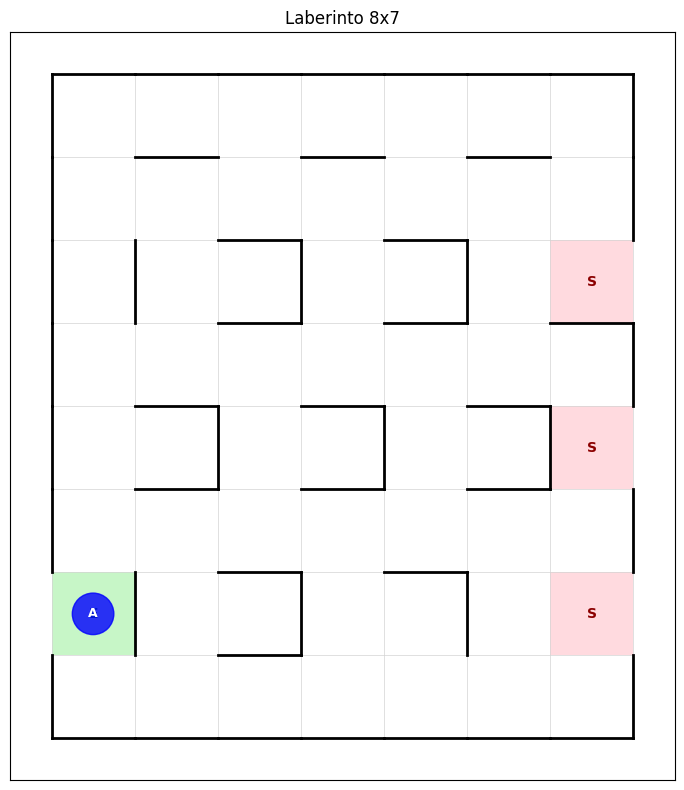

In [5]:
# Crear el entorno con la nueva clase GridWorld
#env = GridWorld('laberintos/project_lab_v2.txt')
env = GridWorld('laberintos/laberinto_8x7.txt')
print('Inicio:', env.start_state, 'Meta:', env.goal_states)

# Visualizar
env.visualize()

In [6]:
# Hiperparámetros
EPISODES = 3000          # Ajusta según convergencia
ALPHA = 0.15             # Tasa de aprendizaje
GAMMA = 0.99             # Factor de descuento
EPSILON_START = 0.9      # Exploración inicial
EPSILON_MIN = 0.01       # Exploración mínima
EPSILON_DECAY = 0.99    # Decaimiento multiplicativo por episodio
MAX_STEPS_EPISODE = 100  # Tope para evitar loops infinitos

# Inicializar entorno y agente
env = GridWorld('laberintos/laberinto_8x7.txt')
agent = QLearningAgent(env, alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON_START)

Entradas detectadas: [(6, 0)]
Salidas detectadas: [(2, 6), (4, 6), (6, 6)]


In [7]:
# Entrenar el agente
episode_rewards, steps_per_episode = agent.run(
    episodes=EPISODES, 
    max_steps_per_episode=MAX_STEPS_EPISODE,
    epsilon_decay=EPSILON_DECAY,
    epsilon_min=EPSILON_MIN
)

Episodio 100 | ε=0.329 | Recompensa media últimas 100: 56.54 | Tiempo transcurrido: 0.14 segundos
Política guardada en qtables/qtable_policy100.json
Episodio 200 | ε=0.121 | Recompensa media últimas 100: 90.40 | Tiempo transcurrido: 0.04 segundos
Política guardada en qtables/qtable_policy200.json
Episodio 300 | ε=0.044 | Recompensa media últimas 100: 92.24 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy300.json
Episodio 400 | ε=0.016 | Recompensa media últimas 100: 92.78 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy400.json
Episodio 500 | ε=0.010 | Recompensa media últimas 100: 92.82 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy500.json
Episodio 600 | ε=0.010 | Recompensa media últimas 100: 92.82 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy600.json
Episodio 700 | ε=0.010 | Recompensa media últimas 100: 92.94 | Tiempo transcurrido: 0.03 segundos
Política

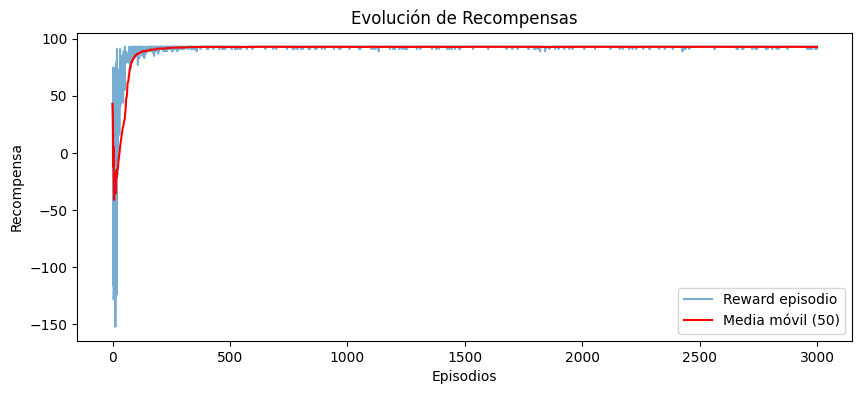

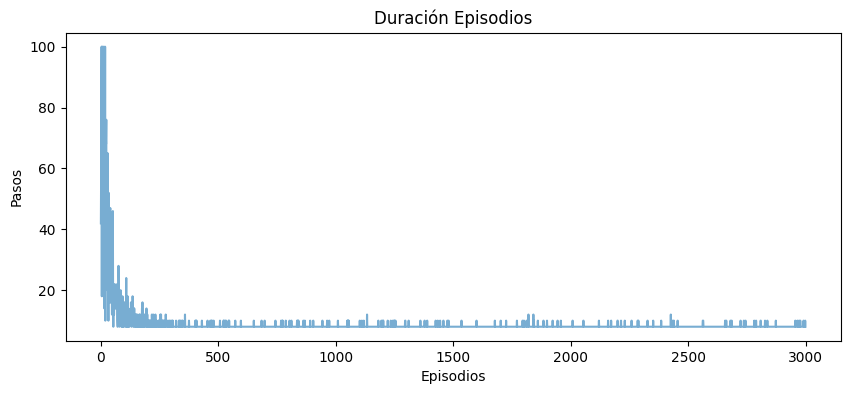

In [8]:
agent.plot_learning_curve(episode_rewards, steps_per_episode)

In [9]:
policy, values = agent.test_performance()

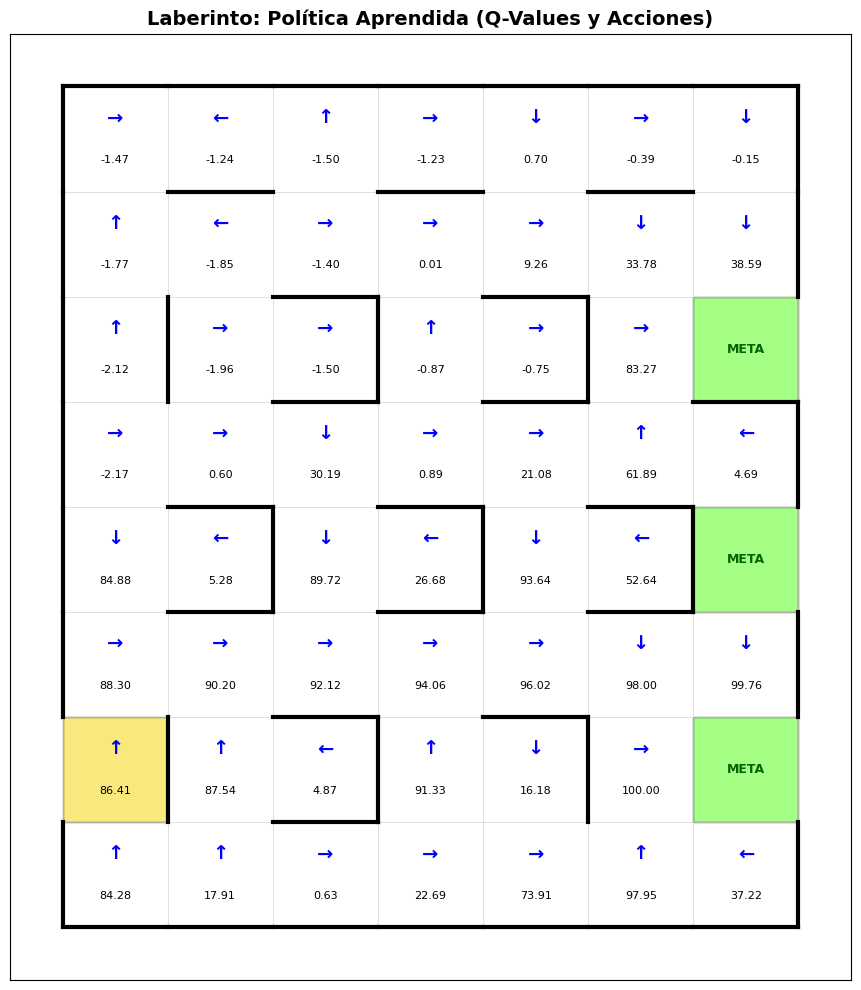

In [10]:
agent.plot_actions(policy, values)

In [14]:
# Crear nuevo agente y cargar política guardada
env_video = GridWorld('laberintos/laberinto_8x7.txt')
agent_video = QLearningAgent(env_video, alpha=0.1, gamma=0.9, epsilon=0.0)  # epsilon=0 para no explorar
agent_video.load_policy('qtables/qtable_policy3000.json')

# Generar GIF
frames = generate_video_with_qvalues(
    agent_video, 
    output_filename='maze_from_qtable.gif', 
    fps=2,
    max_steps=100
    
)

Entradas detectadas: [(6, 0)]
Salidas detectadas: [(2, 6), (4, 6), (6, 6)]
Política cargada desde qtables/qtable_policy3000.json
Trayectoria: 9 estados, 8 acciones
Generando 9 frames...
Guardando GIF en maze_from_qtable.gif...
✓ GIF guardado exitosamente: maze_from_qtable.gif
  Tamaño: 9 frames
  Duración por frame: 500ms
Guardando GIF en maze_from_qtable.gif...
✓ GIF guardado exitosamente: maze_from_qtable.gif
  Tamaño: 9 frames
  Duración por frame: 500ms


### Visualizar el GIF en el notebook

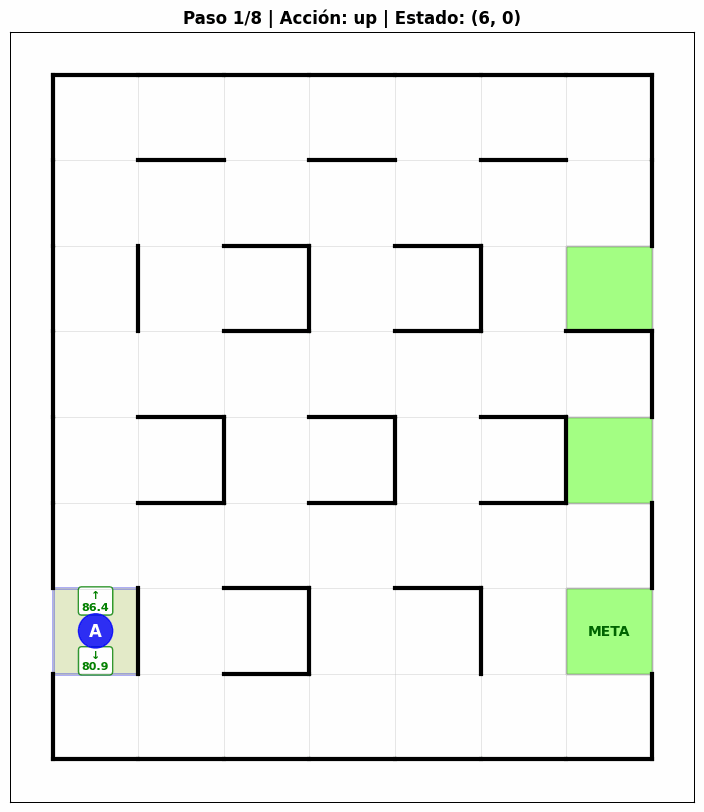

In [15]:
from IPython.display import Image as IPImage, display

# Mostrar GIF en el notebook
display(IPImage(filename='maze_from_qtable.gif'))